In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os
import cv2
import pdb
import time
import random
import numpy as np
import pandas as pd
from tqdm import notebook.tqdm as tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
import albumentations

Some extra packages I'll use to read the DICOM files and to perform Data Augmentations on images / masks

In [2]:
import segmentation_models_pytorch as smp

In [3]:
import pydicom

In [4]:
import glob2
from joblib import Parallel, delayed

## Explore the DICOM data format

Utils to explore a bit the DICOM images and their metadata

In [6]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone) #bone color map helps
    plt.show()

Filename.........: siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5698.1517875189.651634/1.2.276.0.7230010.3.1.3.8323329.5698.1517875189.651633/1.2.276.0.7230010.3.1.4.8323329.5698.1517875189.651635.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 72e2a30e-249e-42e3-874c-ba3e23329612, 
Patient id..........: 72e2a30e-249e-42e3-874c-ba3e23329612
Patient's Age.......: 52
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 135456 bytes
Pixel spacing....: ['0.139', '0.139']


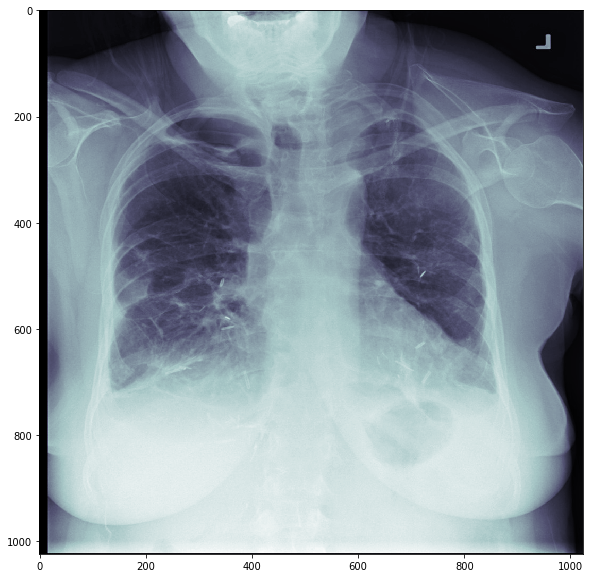

Filename.........: siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.13552.1517875246.585917/1.2.276.0.7230010.3.1.3.8323329.13552.1517875246.585916/1.2.276.0.7230010.3.1.4.8323329.13552.1517875246.585918.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 635aa70c-7103-4f25-83c6-1f6d46064d3e, 
Patient id..........: 635aa70c-7103-4f25-83c6-1f6d46064d3e
Patient's Age.......: 57
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 122208 bytes
Pixel spacing....: ['0.171', '0.171']


Filename.........: siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32688.1517875161.809570/1.2.276.0.7230010.3.1.3.8323329.32688.1517875161.809569/1.2.276.0.7230010.3.1.4.8323329.32688.1517875161.809571.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 84900e4c-eaa8-4d74-8cbe-b91a54346332, 
Patient id..........: 84900e4c-eaa8-4d74-8cbe-b91a54346332
Patient's Age.......: 85
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 107256 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


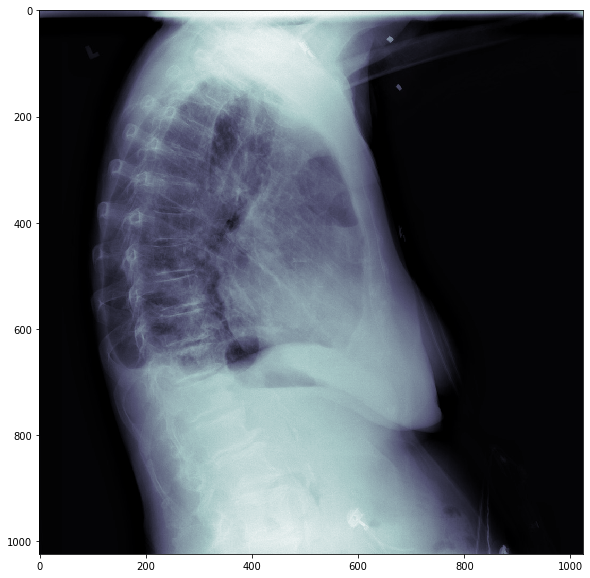

In [8]:
i = 1
num_to_plot = 3
base_path = 'siim/dicom-images-train/'
for file_path in glob2.glob(os.path.join(base_path, '**/*.dcm')):
    dicom_file = pydicom.dcmread(file_path)
    show_dcm_info(dicom_file)
    plot_pixel_array(dicom_file)
    
    if i >= num_to_plot:
        break
    
    i += 1

A few remarks that'll be useful for later:
* the images are 1024x1024 (fairly big as far as images in DL go)
* they're of course grayscale for now, -> 1 channel, but we'll need to reshape them into RGB to use them with pretrained weights (usually on ImageNet)
* they contains informations about pixel spacing, hinting to the real size of the scanned body part
* the DICOM format encodes a host of potentially useful metadata, like age, sex and view position, that might be useful for predictions (for example male sex is detailed as a risk factor according to [Wiki](https://en.wikipedia.org/wiki/Pneumothorax#Cause); They could be encoded via some embedding (`nn.Embedding` module) and fed to the NN, probably at the end of the encoder.

## Let's look at the masks now

The mask data are encoded in a csv file, I'll use `pandas` to open it.

In [14]:
df = pd.read_csv('siim/train-rle.csv',index_col=0)
df.head()

EncodedPixels
ImageId                                                                                              
1.2.276.0.7230010.3.1.4.8323329.6904.1517875201...                                                 -1
1.2.276.0.7230010.3.1.4.8323329.13666.151787524...  557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
1.2.276.0.7230010.3.1.4.8323329.11028.151787522...                                                 -1
1.2.276.0.7230010.3.1.4.8323329.10366.151787522...  514175 10 1008 29 994 30 993 32 991 33 990 34 ...
1.2.276.0.7230010.3.1.4.8323329.10016.151787522...  592184 33 976 58 956 73 941 88 926 102 917 109...

We can see that ([as usual](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py)) binary masks are stored compressed using Run Length Encoding (RLE), `-1`s are used to encode the non-Pneumothorax cases. 

We can decode them failry easily using the following:

In [ ]:
def rle2mask(rle, height=1024, width=1024, fill_value=255):
    mask = np.zeros((height * width,), np.uint8)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        mask[start: end] = fill_value
        start = end
    mask = mask.reshape(width, height).T # .T is important!
    return mask

# for example
mask = rle2mask(df[' EncodedPixels'][1]) # yes, the name string is unstripped -.-"

Let's visualize one, to get more familiar with the data.

In [18]:
def plot_pixel_array(dataset, mask=None, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if mask is not None:
        plt.imshow(mask, alpha=0.3, cmap="Reds")
    plt.show()

i = 0
num_to_plot = 1
base_path = 'siim/dicom-images-train/'
all_files_gen = glob2.glob(os.path.join(base_path, '**/*.dcm'))
for file_path in all_files_gen:
    dicom_file = pydicom.dcmread(file_path)
    # show_dcm_info(dicom_file)
    
    # get the corresponding mask, if it exists
    mask = None
    imageID = file_path.split('/')[-1][:-4]
    mask_rle = df.loc[imageID,' EncodedPixels']
    if (isinstance(mask_rle,str) and mask_rle != '-1'):
        mask = rle2mask(mask_rle)
    elif isinstance(mask_rle,pd.core.series.Series): ## note that we can have >1 regions
        for rle in mask_rle:
            if mask is None:
                mask = rle2mask(rle)
            else:
                mask += rle2mask(rle)

    if mask is not None:
        plot_pixel_array(dicom_file,mask)
        i += 1
    
    if i >= num_to_plot:
        break

#### I'd have no clue as to how to detect the Pneumothorax there! 
I'm glad there are trained radiologiests for that! Can we help them with a Neural NetworK though?

Let's start by converting all files to PNG

In [19]:
def convert_images(filename, outdir):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    cv2.imwrite(outdir + filename.split('/')[-1][:-4] + '.png', img)

In [20]:
train_dcm_list = glob2.glob(os.path.join(base_path, '**/*.dcm'))
train_out_path = 'siim/train_png/'
if not os.path.exists(train_out_path):
    os.makedirs(train_out_path)
res1 = Parallel(n_jobs=8, backend='threading')(delayed(
    convert_images)(i, train_out_path) for i in tqdm(train_dcm_list, total=len(train_dcm_list)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Now let's convert all the data into a DataFrame for convenience, note that the same image can correspond to multiple masks, so we'll need to carefully scan the csv and add them up, taking care of the overlapping parts...

The resulting object will be out Dataset class that we'll need for a later DataLoader

In [22]:
def rle_to_float_mask(rle, height=1024, width=1024, fill_value=1.):
    mask = np.zeros((height * width,), np.float32)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        mask[start: end] = fill_value
        start = end
    mask = mask.reshape(width, height).T # .T is important!
    return mask

class Siim_Dataset(Dataset):

    def __init__(self,
                 df = None,
                 transform = None
                 ):
        self.df = df
        self.transform = transform
        self.names = list(set(df.index))#list(set(df['ImageId']))
        self.base_path = 'siim/train_png/'

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):

        name = self.names[idx]

        image_path = self.base_path+name+'.png'
        image = cv2.imread(image_path)
        rle = self.df.loc[name,' EncodedPixels']

        mask = np.zeros((1024, 1024),dtype=np.float32)
        if (isinstance(rle,str) and rle != '-1'):
            mask += rle_to_float_mask(rle)
            label = torch.FloatTensor([1])            
        elif isinstance(rle,pd.core.series.Series): ## note that we can have >1 regions
            for e in rle:
                mask += rle_to_float_mask(e)
            mask[mask>1.] = 1.
            label = torch.FloatTensor([1])            
        else:
            label = torch.FloatTensor([0])
  
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            # I'll assume that torch tensors come out of here
            image = augmented['image']#.permute(2, 0, 1)
            # the permutation is unnecessary because of ToTensor()
            mask = augmented['mask'].unsqueeze(0)

        return image, mask, label

In [23]:
## use the ToTensorV2 from albumentations 0.5.0 as ToTensor will be deprecated
class ToTensorV2(albumentations.BasicTransform):
    """Convert image and mask to `torch.Tensor`."""

    def __init__(self, always_apply=True, p=1.0):
        super(ToTensorV2, self).__init__(always_apply=always_apply, p=p)

    @property
    def targets(self):
        return {"image": self.apply, "mask": self.apply_to_mask}

    def apply(self, img, **params):
        return torch.from_numpy(img.transpose(2, 0, 1))

    def apply_to_mask(self, mask, **params):
        return torch.from_numpy(mask)

    def get_transform_init_args_names(self):
        return []

    def get_params_dependent_on_targets(self, params):
        return {}


RESIZE_SIZE = 1024//4*3 # shrink to 3/4 size

# mix and match a bit of transforms
transform = albumentations.Compose([
    # albumentations.Resize(RESIZE_SIZE, RESIZE_SIZE),
    # albumentations.OneOf([
    #     albumentations.RandomGamma(gamma_limit=(60, 120), p=0.9),
    #     albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
    #     albumentations.CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=0.9),
    # ]),
    # albumentations.OneOf([
    #     albumentations.Blur(blur_limit=4, p=1),
    #     albumentations.MotionBlur(blur_limit=4, p=1),
    #     albumentations.MedianBlur(blur_limit=4, p=1)
    # ], p=0.5),
    # albumentations.HorizontalFlip(p=0.5),
    # albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20,
    #                                 interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=1),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

In [24]:
ds = Siim_Dataset(df,transform)

print(len(ds))

image, mask, label = ds[0]
image.shape, mask.shape, label

12047


(torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]), tensor([1.]))

Ok everything seems good, the basic dataset is set up!

### Get a baseline model to produce some outputs, to get a feeling for it!

In [25]:
model = smp.Unet('resnet34', classes=1, encoder_weights='imagenet') # resnet34, let's start simple and fast

In [26]:
# let's see what comes out of it
# https://discuss.pytorch.org/t/the-cost-function-for-semantic-segmentation/27668/2

image2, mask2, label2 = ds[3]


batch = torch.cat([image.unsqueeze(0),image2.unsqueeze(0)],dim=0)

with torch.no_grad():
    model.eval()
    pred = model(batch) # batch size of 2
    
pred.shape

torch.Size([2, 1, 1024, 1024])

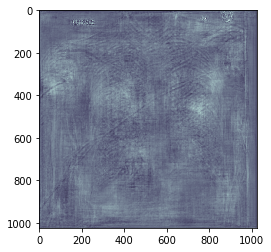

In [27]:
# these are the **logits** for each pixel, output size is batch_size, n_classes, H, W
plt.imshow( pred[1,0] , cmap=plt.cm.bone )
# n_classes in our case is simply 1

Of course this mask is not very useful, as it's just random! Still, because now we've seen that these are logits we know that we'll need to pass each of them into a sigmoid activation when we're ready for the segmentation task!

Let's see how the BCE loss works now

In [28]:
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')
loss_fn2 = torch.nn.BCEWithLogitsLoss(reduction='mean')

target = torch.cat([mask.unsqueeze(0),mask2.unsqueeze(0)],dim=0)

print( batch.shape, pred.shape, target.shape )

with torch.no_grad():
    loss = loss_fn(pred,target)
    loss2 = loss_fn2(pred,target)

print(loss.shape, loss2)

torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1, 1024, 1024]) torch.Size([2, 1, 1024, 1024])
torch.Size([2, 1, 1024, 1024]) tensor(1.2007)


We can also use the Dice loss via the `segmentation models pytorch` package. It also contains the `IoU` (Intersection over Union) that we can use as a metric to monitor training...

In [29]:
loss_fn = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


with torch.no_grad():
    loss = loss_fn(pred,target)

In [30]:
loss

tensor(0.9951)

### Some more data preparation before we can play with the model

We need to extract all the filenames and create a DataFrame with the correct labels and mask for each image.

In [33]:
names = list(set(df.index))
base_path = 'siim/train_png/'

dataframe_list = []
for name in names:
    rle = df.loc[name,' EncodedPixels']

    if (isinstance(rle,str) and rle != '-1'):
        rle = [rle]
        label = 1       
    elif isinstance(rle,pd.core.series.Series): ## note that we can have >1 regions
        rle = list(rle)
        label = 1       
    else:
        rle = ['-1']
        label = 0

    dataframe_list.append([name,rle,label])

In [34]:
df_all = pd.DataFrame(dataframe_list, columns=['ImageId','RLEMasks', 'Labels'])
df_all = df_all.set_index('ImageId')

In [35]:
print(len(df_all))
df_all.head(15)

12047


RLEMasks  \
ImageId                                                                                                 
1.2.276.0.7230010.3.1.4.8323329.11256.151787523...  [294136 1 1020 3 1020 4 1018 5 1018 5 1017 6 1...   
1.2.276.0.7230010.3.1.4.8323329.32394.151787516...  [629881 1 1023 2 1021 4 1020 5 1019 5 1018 6 1...   
1.2.276.0.7230010.3.1.4.8323329.10286.151787522...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.13400.151787524...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.3889.1517875179...  [858673 33 971 68 936 92 867 38 12 109 860 167...   
1.2.276.0.7230010.3.1.4.8323329.1665.1517875168...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.2703.1517875174...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.12689.151787524...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.11808.151787523...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.5502.1517875188...  [150451 5 1015 4 1004 15 1004 18 1002 21 1001 ...   
1.2.276.0.7230010.3.1.4.8323329.11823.151787523...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.32604.151787516...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.2100.1517875171...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.10678.151787522...                                               [-1]   
1.2.276.0.7230010.3.1.4.8323329.14274.151787525...                                               [-1]   

                                                    Labels  
ImageId                                                     
1.2.276.0.7230010.3.1.4.8323329.11256.151787523...       1  
1.2.276.0.7230010.3.1.4.8323329.32394.151787516...       1  
1.2.276.0.7230010.3.1.4.8323329.10286.151787522...       0  
1.2.276.0.7230010.3.1.4.8323329.13400.151787524...       0  
1.2.276.0.7230010.3.1.4.8323329.3889.1517875179...       1  
1.2.276.0.7230010.3.1.4.8323329.1665.1517875168...       0  
1.2.276.0.7230010.3.1.4.8323329.2703.1517875174...       0  
1.2.276.0.7230010.3.1.4.8323329.12689.151787524...       0  
1.2.276.0.7230010.3.1.4.8323329.11808.151787523...       0  
1.2.276.0.7230010.3.1.4.8323329.5502.1517875188...       1  
1.2.276.0.7230010.3.1.4.8323329.11823.151787523...       0  
1.2.276.0.7230010.3.1.4.8323329.32604.151787516...       0  
1.2.276.0.7230010.3.1.4.8323329.2100.1517875171...       0  
1.2.276.0.7230010.3.1.4.8323329.10678.151787522...       0  
1.2.276.0.7230010.3.1.4.8323329.14274.151787525...       0

Now we need to split into a train a validation dataset, I'll use `sklearn` to split, with the `stratify` option, so to maintain the same proportion of positive and negative samples in both subsets.

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
train,validation = train_test_split(df_all, test_size=0.15, random_state=42, stratify = df_all['Labels'] )

In [38]:
train.to_csv(base_path+'train.csv')
validation.to_csv(base_path+'valid.csv')

In [39]:
train_from_csv = pd.read_csv(base_path+'train.csv',index_col=0)
valid_from_csv = pd.read_csv(base_path+'valid.csv',index_col=0)

In [40]:
train_from_csv.head()

RLEMasks  \
ImageId                                                                                                 
1.2.276.0.7230010.3.1.4.8323329.6562.1517875198...  ['594106 43 971 58 956 73 946 83 937 107 912 1...   
1.2.276.0.7230010.3.1.4.8323329.14436.151787525...                                             ['-1']   
1.2.276.0.7230010.3.1.4.8323329.32706.151787516...                                             ['-1']   
1.2.276.0.7230010.3.1.4.8323329.12109.151787523...                                             ['-1']   
1.2.276.0.7230010.3.1.4.8323329.11612.151787523...                                             ['-1']   

                                                    Labels  
ImageId                                                     
1.2.276.0.7230010.3.1.4.8323329.6562.1517875198...       1  
1.2.276.0.7230010.3.1.4.8323329.14436.151787525...       0  
1.2.276.0.7230010.3.1.4.8323329.32706.151787516...       0  
1.2.276.0.7230010.3.1.4.8323329.12109.151787523...       0  
1.2.276.0.7230010.3.1.4.8323329.11612.151787523...       0

In [41]:
valid_from_csv.head()

RLEMasks  \
ImageId                                                                                                 
1.2.276.0.7230010.3.1.4.8323329.6143.1517875196...  ['627760 7 1012 12 1009 14 1007 17 1004 19 100...   
1.2.276.0.7230010.3.1.4.8323329.11842.151787523...                                             ['-1']   
1.2.276.0.7230010.3.1.4.8323329.2799.1517875174...  ['399010 1 1022 3 1022 4 1020 5 1019 9 1014 11...   
1.2.276.0.7230010.3.1.4.8323329.12978.151787524...                                             ['-1']   
1.2.276.0.7230010.3.1.4.8323329.12796.151787524...                                             ['-1']   

                                                    Labels  
ImageId                                                     
1.2.276.0.7230010.3.1.4.8323329.6143.1517875196...       1  
1.2.276.0.7230010.3.1.4.8323329.11842.151787523...       0  
1.2.276.0.7230010.3.1.4.8323329.2799.1517875174...       1  
1.2.276.0.7230010.3.1.4.8323329.12978.151787524...       0  
1.2.276.0.7230010.3.1.4.8323329.12796.151787524...       0

In [42]:
np.sum(train_from_csv['Labels']) / len(train_from_csv), np.sum(valid_from_csv['Labels']) / len(valid_from_csv)

(0.22150600644594198, 0.2217920353982301)


All good it seems! Both csv were correctly written and have similar proportions of positive and negative examples

## Now let's prepare the helper functions we'll use to create the loader to feed the data to the model!

### See you in the [second notebook](./2_SIIM_run.ipynb)!